In [22]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
import sklearn as sln

In [25]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
# data = pd.read_sql_query('SELECT * FROM loan', engine)
# data.head()

In [26]:
query = '''select rental_duration, rental_rate, length, replacement_cost, rating, name from category as c
join film_category as fc
on c.category_id = fc.category_id
join film as f
on f.film_id = fc.film_id
where c.category_id < 5;'''

data = pd.read_sql(query, engine)
data.head()

,rental_duration,rental_rate,length,replacement_cost,rating,name
0,6,0.99,113,20.99,PG,Action
1,3,4.99,129,17.99,R,Action
2,5,2.99,168,11.99,NC-17,Action
3,6,0.99,68,25.99,NC-17,Action
4,6,2.99,129,15.99,G,Action


In [27]:
data.shape

(247, 6)

In [28]:
data.dtypes

rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
name                 object
dtype: object

In [29]:
data['rental_rate'] = data['rental_rate'].astype('object')
data['replacement_cost'] = data['replacement_cost'].astype('float64')
data['rating'] = data['rating'].astype('object')
data['rental_duration'] = data['rental_duration'].astype('object')

In [30]:
data.dtypes

rental_duration      object
rental_rate          object
length                int64
replacement_cost    float64
rating               object
name                 object
dtype: object

In [31]:
data['replacement_cost'].value_counts()

12.99    19
29.99    19
27.99    17
14.99    15
13.99    14
28.99    14
22.99    13
18.99    12
16.99    12
23.99    12
24.99    11
26.99    11
20.99    10
21.99    10
19.99     9
17.99     9
10.99     9
11.99     9
15.99     8
25.99     7
9.99      7
Name: replacement_cost, dtype: int64

In [32]:
data['rental_duration'].value_counts()

3    54
6    52
7    49
5    46
4    46
Name: rental_duration, dtype: int64

In [33]:
data.isna().sum()

rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
name                0
dtype: int64

In [34]:
from scipy import stats
def feat_log_box(df, feature, bins):
    """makes a log Transformation and a boxcox transformation of a feature of a dataframe. \n
    0 values are replaced with the mean in the transformation: \n
    plots 3 distplots next to each other for comparison \n
    tales 3 arguments (df, feature, bins)"""
    df[feature+'_log'] = list(map(lambda x: np.log(x) if np.isfinite(x) else np.NAN, df[feature]))
    df[feature+'_log'] = df[feature+'_log'].fillna(np.mean(df[feature+'_log']))
    df[feature+'_boxcox'] = np.where(df[feature]<=0,0,df[feature])
    mean = np.sum(df[feature+'_boxcox'])/len(df[df[feature+'_boxcox']>0])
    df[feature+'_boxcox'] = df[feature+'_boxcox'].replace(0,mean)
    xt, lmbda = stats.boxcox(df[feature+'_boxcox'])
    df[feature+'_boxcox'] = xt
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,4))
    sns.distplot(df[feature], bins, ax=ax1)
    ax1.set_title(feature)
    sns.distplot(df[feature+'_log'], bins, ax=ax2)
    ax2.set_title(feature + '_log')
    sns.distplot(xt, bins, ax=ax3)
    ax3.set_title(feature + '_boxcox')

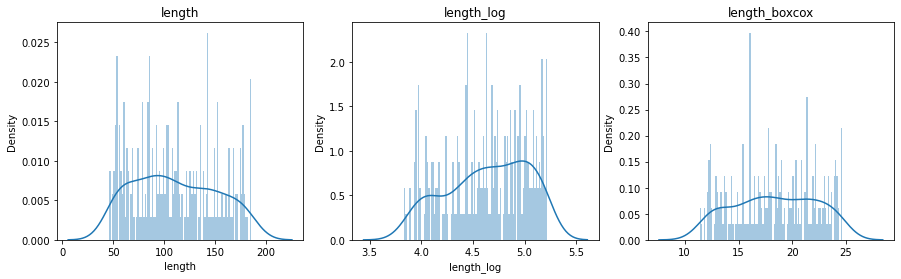

In [35]:
feat_log_box(data, 'length', 100) #keep boxcox

In [36]:
data.drop(['length_log', 'length'], axis=1, inplace = True)

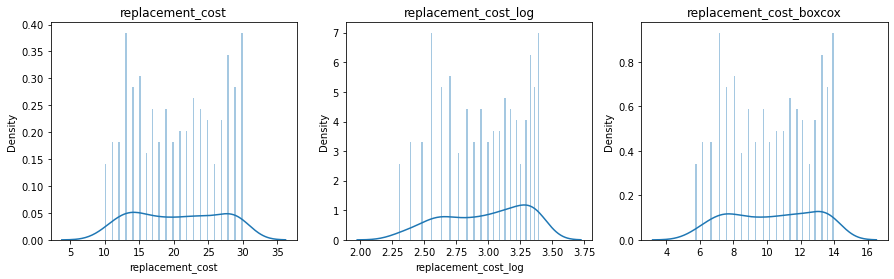

In [37]:
feat_log_box(data, 'replacement_cost', 100)

In [38]:
data.drop(['replacement_cost_log', 'replacement_cost_boxcox'], axis=1, inplace = True)

In [39]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
X = data.select_dtypes(include = np.number)

# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

In [40]:
cat = data.select_dtypes(include = np.object)
cat = cat.drop(['name'], axis=1)
categorical = pd.get_dummies(cat, columns=['rental_duration', 'rental_rate', 'rating'])

In [41]:
y = data['name']
X = np.concatenate((x, categorical), axis=1)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [43]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [44]:
classification.score(X_test, y_test)

0.1919191919191919

In [45]:
predictions = classification.predict(X_test)
predictions

array(['Children', 'Animation', 'Action', 'Children', 'Children',
       'Action', 'Action', 'Classics', 'Children', 'Animation',
       'Animation', 'Action', 'Action', 'Animation', 'Action', 'Children',
       'Action', 'Children', 'Action', 'Animation', 'Children',
       'Animation', 'Children', 'Action', 'Animation', 'Action',
       'Children', 'Animation', 'Animation', 'Animation', 'Children',
       'Children', 'Children', 'Action', 'Action', 'Action', 'Action',
       'Classics', 'Animation', 'Children', 'Children', 'Children',
       'Action', 'Action', 'Action', 'Animation', 'Animation',
       'Animation', 'Action', 'Action', 'Children', 'Action', 'Animation',
       'Animation', 'Animation', 'Action', 'Action', 'Action', 'Children',
       'Action', 'Action', 'Classics', 'Action', 'Action', 'Animation',
       'Children', 'Action', 'Action', 'Children', 'Children', 'Children',
       'Animation', 'Children', 'Animation', 'Action', 'Animation',
       'Animation', 'Children

In [46]:
pd.Series(predictions).value_counts()

Action       41
Children     30
Animation    24
Classics      4
dtype: int64

In [47]:
y_test.value_counts()

Classics     28
Animation    25
Action       24
Children     22
Name: name, dtype: int64

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)


array([[ 9,  5, 10,  0],
       [ 9,  6,  9,  1],
       [10,  5,  4,  3],
       [13,  8,  7,  0]], dtype=int64)

In [49]:
classification.predict_proba(X_test)

array([[0.23486707, 0.17410248, 0.38285344, 0.208177  ],
       [0.25365677, 0.37937019, 0.23526066, 0.13171238],
       [0.38417868, 0.13092137, 0.34390196, 0.14099798],
       [0.21138017, 0.27392517, 0.36984942, 0.14484524],
       [0.22647805, 0.27123371, 0.36454782, 0.13774042],
       [0.48964464, 0.16809884, 0.09492527, 0.24733125],
       [0.36069498, 0.32552072, 0.14800552, 0.16577877],
       [0.26469766, 0.21447682, 0.24502012, 0.2758054 ],
       [0.23410786, 0.23803867, 0.37800062, 0.14985285],
       [0.13933144, 0.34600314, 0.24767613, 0.26698928],
       [0.15180866, 0.49460552, 0.20483979, 0.14874603],
       [0.38119492, 0.13377991, 0.25025258, 0.23477259],
       [0.42260664, 0.08259054, 0.22909052, 0.2657123 ],
       [0.33114004, 0.34606518, 0.15320748, 0.1695873 ],
       [0.44270214, 0.21618229, 0.2124792 , 0.12863637],
       [0.14166809, 0.34625034, 0.34762129, 0.16446028],
       [0.35623647, 0.23863079, 0.23413556, 0.17099719],
       [0.2573755 , 0.17140102,

In [50]:
classification.predict_proba(X_test)[::,0]

array([0.23486707, 0.25365677, 0.38417868, 0.21138017, 0.22647805,
       0.48964464, 0.36069498, 0.26469766, 0.23410786, 0.13933144,
       0.15180866, 0.38119492, 0.42260664, 0.33114004, 0.44270214,
       0.14166809, 0.35623647, 0.2573755 , 0.35684966, 0.18280557,
       0.22539356, 0.18597722, 0.23572428, 0.48388709, 0.14167997,
       0.40146902, 0.16872147, 0.12925706, 0.23427093, 0.16470947,
       0.20680372, 0.11661327, 0.24219488, 0.48706362, 0.44049836,
       0.48344698, 0.50730786, 0.24536617, 0.16979026, 0.21367583,
       0.15808432, 0.24778322, 0.37884677, 0.37681908, 0.48263834,
       0.27662931, 0.23485645, 0.17572558, 0.35628672, 0.47729103,
       0.14982548, 0.37996679, 0.21792112, 0.23091852, 0.14629279,
       0.50340801, 0.32566493, 0.28032077, 0.31614997, 0.353275  ,
       0.45179506, 0.23263656, 0.35952939, 0.54419878, 0.13931594,
       0.1772342 , 0.42882498, 0.29792241, 0.16565643, 0.25357444,
       0.16047689, 0.16111187, 0.31490846, 0.13530739, 0.35060

In [51]:
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0,1,2,3])
n_classes = 4

In [52]:
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data, iris.target

y = label_binarize(y, classes=[0,1,2])
n_classes = 3